# Improving Embeddings with Biased Random Walks in Node2Vec

In [5]:
# Cài đặt thư viện node2vec phiên bản 0.4.6 để thực hiện việc embedding các nút trong đồ thị.
# Sử dụng tham số -q để cài đặt yên lặng, không hiển thị chi tiết quá trình cài đặt.
!pip install -q node2vec==0.4.6

# Cài đặt thư viện gensim phiên bản 4.3.0 để xử lý ngôn ngữ tự nhiên.
# Sử dụng tham số -I để cài đặt lại, bỏ qua các phiên bản đã cài đặt trước đó.
!pip install -qI gensim==4.3.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mizani 0.11.0 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.13.0 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
djangorestframework-filters 0.11.1 requires django-filter~=1.1, but you have django-filter 21.1 which is incompatible.
mizani 0.11.0 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.13.0 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
tensorflow-intel 2.15.0 requires wrapt<1.15,>=1.11.0, but you have wrapt 1.16.0 which is incompatible.


<h4><b> Đầu tiên, chúng ta tạo một hàm tính toán chọn ngẫu nhiên nút tiếp theo trong đồ thị dựa trên nút trước đó, nút hiện tại và hai tham số p và q. </h4>

<h4>1. Chúng ta bắt đầu nhập các thư viện cần thiết: networkx, matplotlib.pyplot để vẽ đồ thị: </h4>

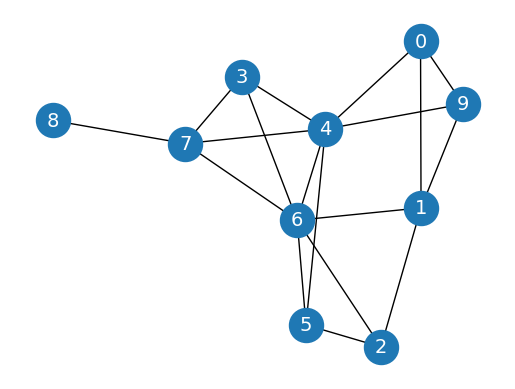

In [53]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

# Plot graph
plt.figure()
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

<h4>Nếu ta muốn các nút khác màu thì dùng code sau</h4>

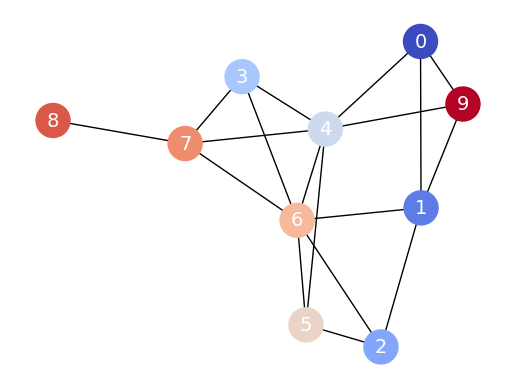

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

# Generate node colors (randomly or by some metric)
node_colors = range(len(G.nodes))

# Plot graph
plt.figure()
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 node_color=node_colors,  # Provide data for colormapping
                 cmap='coolwarm',  # Colormap to use
                 font_size=14,
                 font_color='white'
                 )

plt.show()


<h4>2. Chúng ta import các thư viện random, numpy và khai báo hàm next_node  với danh sách các tham số:  </h4>

In [55]:
import random
random.seed(0)
import numpy as np
np.random.seed(0)

def next_node(previous, current, p, q):
    # Khởi tạo một danh sách các giá trị alpha:
    alphas = []

    # Chúng ta lấy danh sách các nút lân cận từ nút hiện tại:
    # Get the neighboring nodes
    neighbors = list(G.neighbors(current))
    
    ''' Với mỗi nút lân cận, chúng ta cần tính toán giá trị alpha thích hợp: 1/p nếu nút lân cận là nút trước đó, 
    1 nếu nút lân cận được kết nối với nút trước đó, và 1/q cho trường hợp còn lại'''
    # Calculate the appropriate alpha value for each neighbor
    for neighbor in neighbors:
        # Distance = 0: probability to return to the previous node
        if neighbor == previous:
            alpha = 1/p
        # Distance = 1: probability of visiting a local node
        elif G.has_edge(neighbor, previous):
            alpha = 1
        # Distance = 2: probability to explore an unknown node
        else:
            alpha = 1/q
        alphas.append(alpha)

    # Chúng ta chuẩn hóa các giá trị này để tạo ra các xác suất:
    # Normalize the alpha values to create transition probabilities
    probs = [alpha / sum(alphas) for alpha in alphas]
    
    # Chúng ta chọn ngẫu nhiên nút tiếp theo dựa trên các xác suất chuyển tiếp đã được tính toán trước đó. 
    # Randomly select the new node based on the transition probabilities
    next = np.random.choice(neighbors, size=1, p=probs)[0]
    return next

<p>Trước khi kiểm tra hàm này, chúng ta cần code cho các bước đi ngẫu nhiên.  </p>

In [56]:
def random_walk(start, length, p, q):
    walk = [start]
    
    for i in range(length):
        current = walk[-1]
        previous = walk[-2] if len(walk) > 1 else None
        next = next_node(previous, current, p, q)
        walk.append(next)
    
    return walk

<p>Chúng ta có đã có đầy đủ các yếu tố để khởi tạo các bước ngẫu nhiên. Hãy thử với độ dài 5, p=1, q=1. 

Hàm này sẽ trả về dòng sau: [0, 4, 7, 6, 4, 5, 4, 5, 6] </p>

In [57]:
random_walk(0, 8, p=1, q=1)

[0, 4, 7, 6, 4, 5, 4, 5, 6]

<p> Kết quả này là ngẫu nhiên vì mỗi nút lân cận đều có cùng 1 xác suất chuyển tiếp. Với các tham số này, chúng ta tái tạo chính xác thuật toán Deepwalk. 

Bây giờ, hãy làm lệch các bước đi để quay trở lại nút trước đó với q = 10

Hàm này sẽ trả về dòng sau: [0, 9, 1, 9, 1, 9, 1, 0, 1]</p>

In [58]:
random_walk(0, 8, p=1, q=10)

[0, 9, 1, 9, 1, 9, 1, 0, 1]

<p> Lần này, bước đi ngẫu nhiên khám phá nhiều nút hơn trong đồ thị. Bạn có thể thấy rằng nó không bao giờ quay lại nút trước đó vì xác suất thấp với p = 10. 

Hàm này sẽ trả về dòng sau: [0, 1, 9, 4, 7, 8, 7, 4, 6] </p>

In [59]:
random_walk(0, 8, p=10, q=1)

[0, 1, 9, 4, 7, 8, 7, 4, 6]

<h2>Triển khai Node2Vec </h2>

<p>Khi chúng ta đã có các hàm để tạo các bước đi ngẫu nhiên thiên lệch, việc triển khai Node2Vec rất giống với việc triển khai DeepWalk. 

Thực ra, nó giống đến mức chúng ta có thể sử dụng lại mã nguồn giống nhau và tạo các chuỗi với p = 1  và  q = 1 để triển khai DeepWalk như là một trường hợp đặc biệt của Node2Vec.

Như trong chương trước, mục tiêu của chúng ta là phân loại chính xác từng thành viên của câu lạc bộ vào một trong hai nhóm (“Mr. Hi” và “Officer”). Chúng ta sẽ sử dụng các vector nhúng của nút được cung cấp bởi Node2Vec làm đầu vào cho một bộ phân loại máy học (trong trường hợp này là Random Forest). </p>

In [60]:
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load dataset
G = nx.karate_club_graph()

# Chúng ta chuyển đổi các nhãn của các nút thành các giá trị số (0 và 1):
# Process labels (Mr. Hi = 0, Officer = 1)
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

''' Chúng ta tạo một danh sách các bước đi ngẫu nhiên như đã đề cập trước bằng cách sử dụng hàm random_walk() 80 lần 
cho mỗi nút trong đồ thị. Các tham số được chỉ định như sau (tương ứng với 2 và 1): '''
# Create a list of random walks
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10, 3, 2))

# Chúng ta tạo một phiên bản của Word2Vec (mô hình skip-gram) với hàm softmax phân cấp: 
# Create and train Word2Vec for DeepWalk
node2vec = Word2Vec(walks,
                hs=1,   # Hierarchical softmax
                sg=1,   # Skip-gram
                vector_size=100,
                window=10,
                workers=2,
                min_count=1,
                seed=0)
# Mô hình skip-gram được huấn luyện trên các chuỗi mà chúng ta đã tạo ra trong 30 vòng lặp: 
node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=30, report_delay=1)

# Chúng ta tạo các labels (nhãn) để huấn luyện và kiểm tra bộ phân loại: 
# Create masks to train and test the model
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
labels = np.array(labels)

# Bộ phân loại Random Forest được huấn luyện trên dữ liệu huấn luyện: 
# Train Node2Vec classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(node2vec.wv[train_mask], labels[train_mask])

# Chúng ta đánh giá nó dựa trên độ chính xác của dữ liệu kiểm tra:
# Evaluate accuracy
y_pred = clf.predict(node2vec.wv[test_mask])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Node2Vec accuracy = {acc*100:.2f}%')

Node2Vec accuracy = 95.45%


<p>Điều này có nghĩa là mô hình Node2Vec đạt độ chính xác 95.45% trên dữ liệu kiểm tra.

<b>Ý Nghĩa Cụ Thể</b>

- Hiệu suất cao: Độ chính xác 95.45% cho thấy mô hình Node2Vec hoạt động rất tốt trong việc phân loại hoặc dự đoán các trường hợp trong tập dữ liệu kiểm tra. Đây là một kết quả rất cao và cho thấy mô hình có khả năng tổng quát tốt từ dữ liệu huấn luyện.

- Tính tổng quát: Kết quả này cho thấy mô hình không chỉ học tốt từ dữ liệu huấn luyện mà còn có khả năng áp dụng các kiến thức đã học để đưa ra dự đoán chính xác trên dữ liệu chưa thấy trước đó.

- Đánh giá hiệu quả: Độ chính xác cao như vậy giúp khẳng định rằng Node2Vec là một phương pháp hiệu quả cho bài toán hiện tại, trong khi độ chính xác thấp có thể chỉ ra rằng mô hình cần được cải thiện hoặc có vấn đề với dữ liệu hoặc cách huấn luyện.

Tuy nhiên, độ chính xác không phải lúc nào cũng là chỉ số duy nhất để đánh giá mô hình. Trong các bài toán có phân phối lớp không cân bằng hoặc các yếu tố khác, các chỉ số như độ nhạy (recall), độ chính xác (precision), và điểm F1 (F1 score) có thể cũng cần được xem xét để có cái nhìn toàn diện hơn về hiệu suất của mô hình.
</p>

<h2>Xây dựng hệ thống gợi ý phim (Building a movie RecSys)</h2>

<p> Trước tiên, hãy tải xuống một tập dữ liệu. 
    
MovieLens là một lựa chọn phổ biến, với phiên bản nhỏ của tập dữ liệu mới nhất (09/2018) gồm 100.836 đánh giá, 9.742 bộ phim, và 610 người dùng. Chúng ta có thể tải xuống với đoạn mã Python sau: </p>

In [61]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

<p>Chúng ta quan tâm đến hai tệp: ratings.csv và movies.csv. Tệp đầu tiên lưu trữ tất cả các đánh giá do người dùng thực hiện, và tệp thứ hai cho phép chúng ta dịch các mã định danh phim thành tiêu đề.

Hãy xem chúng trông như thế nào bằng cách nhập chúng vào với pandas bằng lệnh pd.read_csv(): 
</p>

In [62]:
import pandas as pd

ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
ratings

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


<p>Bây giờ hãy nhập tệp movies.csv</p>

In [63]:
movies = pd.read_csv('ml-100k/u.item', sep='|', usecols=range(2), names=['movie_id', 'title'], encoding='latin-1')
movies

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


<p>Ở đây, chúng ta muốn xem những bộ phim được cùng một người dùng thích. Điều này có nghĩa là các xếp hạng như 1, 2 và 3 không liên quan lắm. Chúng ta có thể loại bỏ những xếp hạng đó và chỉ giữ lại điểm 4 và 5: </p>

In [64]:
# Only consider ratings with the highest score
ratings = ratings[ratings.rating >= 4]
ratings

,user_id,movie_id,rating,unix_timestamp
5,298,474,4,884182806
7,253,465,5,891628467
11,286,1014,5,879781125
12,200,222,5,876042340
16,122,387,5,879270459
...,...,...,...,...
99988,421,498,4,892241344
99989,495,1091,4,888637503
99990,806,421,4,882388897
99991,676,538,4,892685437


<p>Bây giờ chúng ta có 48.580 lượt đánh giá từ 610 người dùng. Bước tiếp theo là đếm mỗi lần hai bộ phim được yêu thích bởi cùng một người dùng. Chúng ta sẽ lặp lại quá trình này cho từng người dùng trong tập dữ liệu. 

Để đơn giản hóa mọi thứ, chúng ta sẽ sử dụng cấu trúc dữ liệu defaultdict, giúp tự động tạo các mục còn thiếu thay vì gây ra lỗi. Chúng ta sẽ sử dụng cấu trúc này để đếm các bộ phim được cùng thích: </p>

In [65]:
from collections import defaultdict

pairs = defaultdict(int)

# Chúng ta sẽ lặp qua toàn bộ danh sách người dùng trong tập dữ liệu của mình: 
# Loop through the entire list of users
for group in ratings.groupby("user_id"):
    # Chúng ta lấy danh sách các bộ phim đã được người dùng hiện tại yêu thích: 
    # List of IDs of movies rated by the current user
    user_movies = list(group[1]["movie_id"])

    # Chúng ta tăng giá trị của một bộ đếm cụ thể cho một cặp phim mỗi khi chúng được xem cùng nhau trong cùng một danh sách 
    # Count every time two movies are seen together
    for i in range(len(user_movies)):
        for j in range(i+1, len(user_movies)):
            pairs[(user_movies[i], user_movies[j])] += 1

<p>Đối tượng pairs hiện đang lưu trữ số lần hai bộ phim được cùng một người dùng thích. Chúng ta có thể sử dụng thông tin này để xây dựng các cạnh của đồ thị của chúng ta như sau. 
</p>

In [66]:
# Chúng ta tạo một đồ thị sử dụng thư viện networkx:
# Create a networkx graph
G = nx.Graph()

# Đối với mỗi cặp phim trong cấu trúc pairs, chúng ta phân tích hai bộ phim và điểm số tương ứng của chúng s
# Try to create an edge between movies that are liked together
for pair in pairs:
    movie1, movie2 = pair
    score = pairs[pair]

    '''Nếu điểm số này cao hơn 10, chúng ta thêm một liên kết có trọng số vào đồ thị để kết nối cả hai bộ phim 
    dựa trên điểm số này. Chúng ta không xem xét các điểm số thấp hơn 10 vì điều đó sẽ tạo ra một đồ thị lớn 
    trong đó các kết nối sẽ kém ý nghĩa hơn '''
    # The edge is only created when the score is high enough
    if score >= 20:
        G.add_edge(movie1, movie2, weight=score)

print("Total number of graph nodes:", G.number_of_nodes())
print("Total number of graph edges:", G.number_of_edges())

Total number of graph nodes: 410
Total number of graph edges: 14936


<p>Đồ thị mà chúng ta đã tạo có 410 nút (phim) và 14.936 cạnh. Chúng ta có thể huấn luyện Node2Vec trên nó để học các nhúng nút (node embeddings)!</p>

<p>Chúng ta có thể tái sử dụng triển khai của mình từ phần trước, nhưng thực ra có một thư viện Python chuyên dụng cho Node2Vec (cũng gọi là node2vec). 
    
Hãy thử sử dụng thư viện này trong ví dụ sau:: </p>

In [67]:
# Cài đặt thư viện node2vec và import lớp Node2Vec: 
# !pip install node2vec (ta đã install node2vec ở đầu bài)
from node2vec import Node2Vec

''' Chúng ta tạo một thể hiện (instance - đối tượng) của Node2Vec sẽ tự động sinh các bước đi ngẫu nhiên có thiên lệch 
dựa trên các tham số p và q như sau:'''
node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, p=2, q=1, workers=1)

# Chúng ta huấn luyện một mô hình trên các bước đi ngẫu nhiên có thiên lệch với cửa sổ là 10 (5 nút trước, 5 nút sau) như sau: 
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/410 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.41it/s]


<p>Sau khi mô hình Node2Vec đã được huấn luyện, chúng ta có thể sử dụng nó theo cách tương tự như đối tượng Word2Vec từ thư viện gensim. 
    
Dưới đây là một hàm để gợi ý phim dựa trên một tiêu đề phim đã cho:</p>

In [68]:
'''Chúng ta tạo hàm recommend(), hàm này lấy tiêu đề phim làm đầu vào. Nó bắt đầu bằng cách chuyển đổi tiêu đề 
thành ID phim mà chúng ta có thể sử dụng để truy vấn mô hình của mình: '''
def recommend(movie):
    movie_id = str(movies[movies.title == movie].movie_id.values[0])

    ''' Chúng ta sẽ lặp qua năm vector từ có độ tương đồng cao nhất. Chúng ta chuyển các ID này thành tiêu đề phim 
    và in ra cùng với các điểm tương đồng tương ứng:'''
    for id in model.wv.most_similar(movie_id)[:5]:
        title = movies[movies.movie_id == int(id[0])].title.values[0]
        print(f'{title}: {id[1]:.2f}')

# Chúng ta gọi hàm này để có được năm bộ phim giống nhất với Star Wars về mặt độ tương đồng cosin 
recommend('Star Wars (1977)')

Return of the Jedi (1983): 0.61
Raiders of the Lost Ark (1981): 0.55
Godfather, The (1972): 0.49
Indiana Jones and the Last Crusade (1989): 0.46
White Squall (1996): 0.44


## Mật độ tương đồng cosin (cosine similarity)

<p>Mật độ tương đồng cosin (cosine similarity) là một chỉ số dùng để đo lường độ tương đồng giữa hai vector trong không gian vector. Đây là một phương pháp phổ biến trong xử lý ngôn ngữ tự nhiên, khai thác dữ liệu và học máy.

</p>

![Hình ảnh](https://raw.githubusercontent.com/Trantamming/Data_mangXH/main/H%C3%ACnh%20cong%20th%E1%BB%A9c%20t%C3%ADnh%20m%E1%BA%ADt%20%C4%91%E1%BB%99%20t%C6%B0%C6%A1ng%20%C4%91%C3%B4ng%20cosin2.jpg)

<p>
Trong hầu hết các ứng dụng, giá trị của cosine similarity thường nằm trong khoảng từ 0 đến 1, vì các vector thường được chuẩn hóa và các ứng dụng chủ yếu làm việc với giá trị dương.
</p>